### importing required librairies

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing



### importing the clean data

In [90]:
dataExtracted = pd.read_csv('./CleanDataForTimeSeries.csv') #import
dataExtracted.sample(5) #sample 5 rows


,Date,nombre_pannes,Year,sin_day,quarter,cos_day,day_of_week,day,dayofmonth,week,month,lag_1,lag_2,lag_3,lag_4,lag_6,lag_9
353,2019-12-20,33.0,2019,0.841455,4,-0.540328,4,20,20,51,12,18.0,15.0,22.0,12.0,6.0,12.0
950,2021-08-11,7.0,2021,0.053053,3,-0.998592,2,11,11,32,8,10.0,9.0,9.0,8.0,9.0,6.0
1109,2022-02-19,12.0,2022,-0.262375,1,0.964966,5,19,19,7,2,25.0,33.0,40.0,28.0,8.0,13.0
962,2021-08-23,6.0,2021,0.580587,3,-0.814198,0,23,23,34,8,9.0,13.0,16.0,13.0,8.0,8.0
92,2019-04-03,13.0,2019,-0.948282,2,0.317429,2,3,3,14,4,11.0,7.0,7.0,14.0,19.0,9.0


### plotting the data (because it looks good :3)

In [91]:
data1z = dataExtracted.copy()

fig = px.line(data1z, x='Date', y='nombre_pannes', title='Distribution du nombre des interventions (Annuelle-Mensuelle-Hebdomadaire)')

fig.update_xaxes(
    rangeslider_visible=False,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()


In [92]:
dataExtracted.set_index('Date', inplace=True)
df=dataExtracted[["nombre_pannes"]]


### splitting the data

In [93]:
split_date = '2021-02-25'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")


785 days of training data 
 336 days of testing data 


## SES Method for Failure Prediction:
### The Simple Exponential Smoothing (SES) method predicts the next value in a time series by weighting past observations, with recent data given more importance. It’s ideal for non-stationary data without trends or seasonality.

### Key components in the implementation:

- yhat: Stores the predicted values.

- tqdm: Displays a progress bar for the prediction loop.

- temp_train: Contains the training data, progressively updated with predicted test data.

- model: The SES model is instantiated and trained using SimpleExpSmoothing.

- model_fit: The fit() function trains the model and returns the learned coefficients.

- predictions: The predict() function generates forecasts based on the trained model.

- This method is effective for simple forecasts but may struggle with data that has clear trends or seasonality.

#### this part is for evaluation in the furute

In [94]:
EPSILON = 1e-10
class metrics :


       EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


#-------------Début metrcis

def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)
#----- Fin métrics

METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}

#--------------------def evaulate
def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "mse")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

### importing and training the model

In [95]:
# Instialisation des Dictionnaires
resultsDict = {}
predictionsDict = {}
# Parcourez les données de test, entraînez-vous et prédisez 1 jour à l'avance pour toutes les données de test
index = len(df_training)
yhat = list() 

for t in tqdm(range(len(df_test.nombre_pannes))):
    temp_train = dataExtracted[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.nombre_pannes) #une instance de la classe SimpleExpSmoothing doit être instanciée et transmise aux données d'apprentissage
    model_fit_expo = model.fit()
    predictions = model_fit_expo.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat) # list to dataframe
resultsDict['SES'] = evaluate(df_test.nombre_pannes, yhat.values)
predictionsDict['SES'] = yhat.values

  0%|          | 0/336 [00:00<?, ?it/s]

c:\Users\User\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\User\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

  0%|          | 1/336 [00:01<10:23,  1.86s/it]c:\Users\User\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Val

### predicted x real

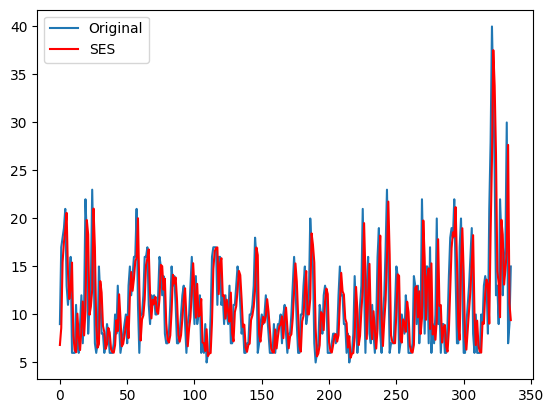

In [96]:
plt.plot(df_test.nombre_pannes.values, label='Original')
plt.plot(yhat.values, color='red', label='SES')
plt.legend()

### Evaluation

In [97]:

from sklearn.metrics import mean_absolute_error


mae = mean_absolute_error(df_test.nombre_pannes, yhat)
rmse = np.sqrt(mean_squared_error(df_test.nombre_pannes, yhat))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 3.301392823084439
RMSE: 4.465243610954275


Model Evaluation Results:
Mean Absolute Error (MAE): 3.30

-This indicates that, on average, the model's predictions deviate by 3.30 units from the actual values.

Root Mean Squared Error (RMSE): 4.47

-This represents the average magnitude of the prediction errors, with larger errors weighted more heavily due to squaring. The model's error magnitude is approximately 4.47 units.

These results suggest that the model performs reasonably well, but there's still room for improvement.

### I shall now try forecasting with my blessed model

In [98]:
datelist = pd.date_range(start="2022-03-04",end="2024-04-01")
data_forecast = pd.DataFrame(datelist, columns = ['Date'])
forecast= model_fit_expo.predict(360)
forecast=forecast.reset_index()
forecast.Date=datelist

In [99]:
forecast.head(10)

,Date,0
0,2022-03-04,9.599172
1,2022-03-05,7.521426
2,2022-03-06,7.104605
3,2022-03-07,6.221597
4,2022-03-08,6.044455
5,2022-03-09,6.808306
6,2022-03-10,6.961544
7,2022-03-11,13.387385
8,2022-03-12,11.478939
9,2022-03-13,7.099144


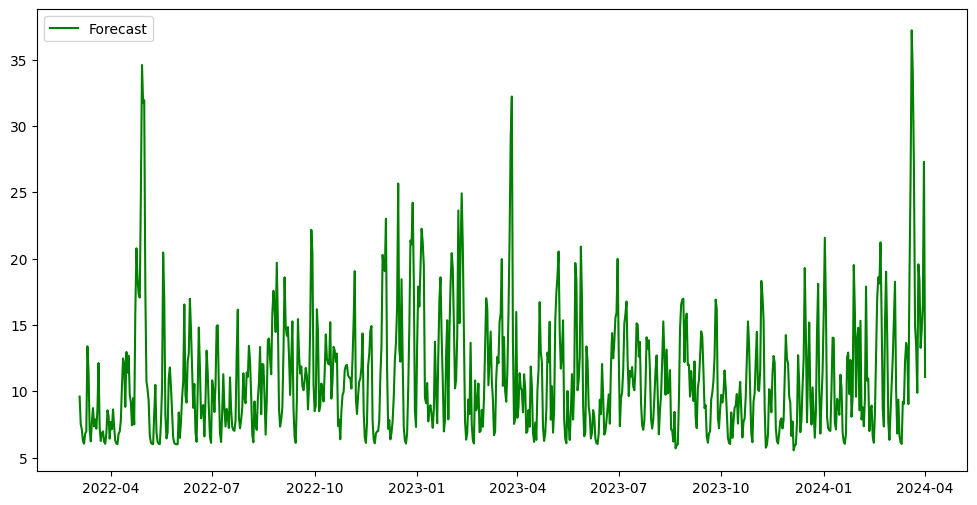

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(forecast['Date'], forecast[0], color='green', label='Forecast')
plt.legend()
